In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

In [2]:
# ## Helper function for plotting opencv images in notebook
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

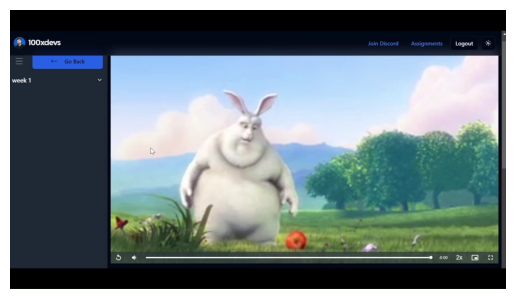

In [3]:
cap = cv2.VideoCapture("main_edited_copy_2.mp4")
cap2 = cv2.VideoCapture("frame_1_edited.mp4")
ret, frame1 = cap.read()
ret, frame2 = cap2.read()
# Convert BGR to RGB
frame_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(frame_rgb)
plt.axis('off')  # Turn off axis
plt.show()

In [4]:
def highlight_frame_differences(frame1, frame2):
    # Compute absolute difference between the frames
    threshold=3
    significant_change_threshold=0.005
    diff = cv2.absdiff(frame1, frame2)
    
    blur_kernel_size=(5, 5)
    blurred_diff = cv2.GaussianBlur(diff, blur_kernel_size, 0)
    
    # Enhance the differences for better visualization
    _, diff_highlighted = cv2.threshold(blurred_diff, threshold, 255, cv2.THRESH_BINARY)

    # Calculate the proportion of pixels that have significant differences
    num_significant_pixels = np.sum(diff_highlighted == 255)
    print(num_significant_pixels, "num_significant_pixels")
    total_pixels = frame1.size
    change_proportion = num_significant_pixels / total_pixels
    
    # Determine if the change is significant
    is_significant_change = change_proportion > significant_change_threshold
    
    return diff_highlighted, is_significant_change
    
    # return diff

In [5]:
def compareFrameChanges(frame1, frame2):
    threshold=3
    significant_change_threshold=0.005
    diff = cv2.absdiff(frame1, frame2)
    
    blur_kernel_size=(5, 5)
    blurred_diff = cv2.GaussianBlur(diff, blur_kernel_size, 0)
    
    # Enhance the differences for better visualization
    _, diff_highlighted = cv2.threshold(blurred_diff, threshold, 255, cv2.THRESH_BINARY)

    # Calculate the proportion of pixels that have significant differences
    num_significant_pixels = np.sum(diff_highlighted == 255)
    # print(num_significant_pixels, "num_significant_pixels")
    total_pixels = frame1.size
    change_proportion = num_significant_pixels / total_pixels
    
    # Determine if the change is significant
    is_significant_change = change_proportion > significant_change_threshold
    
    return is_significant_change

In [6]:
from PIL import Image
import imagehash

def compute_frame_phash(gray_frame):
    # Convert frame to grayscale
    # gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    # blurred_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)
    
    # # Resize frame to a smaller size
    # resized_frame = cv2.resize(blurred_frame, (256, 256))  # Adjust size as needed
    
    # Convert to PIL Image
    pil_image = Image.fromarray(gray_frame)
    
    # Compute perceptual hash
    phash = imagehash.phash(pil_image, hash_size=16, highfreq_factor=16)
    # return str(phash)
    return phash

In [7]:
def preprocess_frame(frame, blur_kernel_size=(5, 5)):
    """Preprocess the frame by converting to grayscale and applying Gaussian blur."""
    try:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    except cv2.error as e:
        print(f"Error converting frame to grayscale: {e}")
        print(f"Frame shape: {frame.shape}, Frame type: {type(frame)}")
        return None
    
    frame = cv2.GaussianBlur(frame, blur_kernel_size, 0)

    return frame

In [8]:
import cv2
import hashlib

def get_frame_hashes(video_path):
    cap = cv2.VideoCapture(video_path)
    hash_digests = []
    strings = []
    phash=[]
    frames=[]

    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f'FPS : {fps:0.2f}')

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = preprocess_frame(frame)
        frames.append(frame)
        # size = sys.getsizeof(frame)
        # print(size/ (1024 * 1024))
        phash.append(compute_frame_phash(frame))
        # gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hash_object = hashlib.md5(frame.tobytes())
        # hash_object = hashlib.md5(frame.tobytes())
        hash_digest = hash_object.hexdigest()
        hash_digests.append(hash_digest)
        # hash_digests.append(frame)

    cap.release()
    return hash_digests, strings, phash, frames

In [9]:
# hash_digests1, strings1, phash1, frames1 = get_frame_hashes('main_edited_copy_2.mp4')
hash_digests1, strings1, phash1, frames1 = get_frame_hashes('outputMerged.mp4')
# hash_digests1, strings1, phash1, frames1 = get_frame_hashes('3_frames_edited.mp4')
# len(hash_digests1)

FPS : 29.94


In [10]:
# hash_digests2, strings2, phash2, frames2 = get_frame_hashes('frame_1_edited.mp4')
# hash_digests2, strings2, phash2, frames2 = get_frame_hashes('2_frames_edited.mp4')
# hash_digests2, strings2, phash2, frames2 = get_frame_hashes('added_15_frames.mp4')
hash_digests2, strings2, phash2, frames2 = get_frame_hashes('deleted_15_frames.mp4')
# hash_digests2, strings2, phash2, frames2 = get_frame_hashes('main_edited_copy_2.mp4')

FPS : 30.00


In [11]:
def is_significantly_different(hash1, hash2, threshold=5):
    return hash1 - hash2 > threshold

In [12]:
# for i in range(len(phash1)):
#     currphash1=phash1[i]
#     currphash2=phash2[i]
#     if is_significantly_different(currphash1, currphash2):
#         print("Timestamp: ", i/30)
#         for j in range(1,30):
#             newphash1=phash1[i+j]
#             if newphash1==currphash2:
#                 print(i, j, i+j)
            # if is_significantly_different(newphash1, currphash2):
            #     print(i+j)
        # print(i)
print(len(phash1), len(phash2))
i,j=0,0
deleted=[]
added=[]
changedFrames=[]
while i<len(phash1) and j<len(phash2):
    currphash1=phash1[i]
    currphash2=phash2[j]
    if is_significantly_different(currphash1, currphash2):
        # print(currphash1-currphash2)
        # print("Timestamp: ", j)
        flag=True
        if (len(phash1)!=len(phash2)):
            for k in range(1,60):
                if i + k >= len(phash1):
                    break
                newphash1=phash1[i+k]
                if newphash1==currphash2:
                    if k+1<15: # doubt-----------------------------------------------------------
                        break
                    print(i, i+k, i/30, "-", (i+k)/30)
                    deleted.append((i,i+k-1))
                    i=i+k
                    print(i/30)
                    flag=False
                    break
            
            if flag:
                for k in range(1,60):
                    if j + k >= len(phash2):
                        break
                    newphash2=phash2[j+k]
                    if currphash1==newphash2:
                        if k+1<15: # doubt-----------------------------------------------------------
                            break
                        print(j, j+k, j/30, "-", (j+k)/30)
                        added.append((j,j+k-1))
                        j=j+k
                        print(j/30)
                        flag=False
                        break
                
        if flag:
            changedFrames.append(j)
            # print("J=",j)
            
    i+=1
    j+=1
print(deleted)
print(added)
print(changedFrames)

670 670
[]
[]
[]


In [13]:
# new_length_of_streams=[]
previous_length_of_streams=[]
i=len(frames1)
while i>=0 and i//300!=0:
    previous_length_of_streams.append(300)
    i-=300

if i%300!=0:
    previous_length_of_streams.append(i%300)

print(previous_length_of_streams)

[300, 300, 70]


In [14]:
changedSegments=set()

In [15]:
new_length_of_streams=previous_length_of_streams[:]

# For deleted Frames
for deletedFrame in deleted:
    start=deletedFrame[0]
    end=deletedFrame[1]

    index=start//300
    changedSegments.add(index)
    print(index, previous_length_of_streams[index])
    new_length_of_streams[index]-=end-start+1

print(new_length_of_streams)
print(changedSegments)

[300, 300, 70]
set()


In [16]:
# new_length_of_streams=previous_length_of_streams[:]

# For added frames
for addedFrame in added:
    start=addedFrame[0]
    end=addedFrame[1]

    index=start//300
    changedSegments.add(index)
    print(index, previous_length_of_streams[index])
    new_length_of_streams[index]+=end-start+1

print(new_length_of_streams)
print(changedSegments)

[300, 300, 70]
set()


In [17]:
for frame in changedFrames:
    index=frame//300
    changedSegments.add(index)
    print(index, frame)
print(new_length_of_streams)
print(changedSegments)

[300, 300, 70]
set()


In [18]:
import os
import subprocess

VIDEO_ID="video1hls"

# Function to convert frames to time (seconds)
def frames_to_time(frame_count, fps):
    return round(frame_count / fps, 3)  # Round to 3 decimal places for better precision

# Function to generate HLS segment for each frame range
def generate_hls_segment(video_file, start_time, duration, output_dir, segment_num):
    segment_path = os.path.join(output_dir, f"segment_{segment_num}.ts").replace("\\", "/")
    
    cmd = [
        "ffmpeg",
        "-y",
        "-ss", str(start_time),  # Start time
        "-i", video_file,        # Input video file
        "-t", str(duration),     # Duration of the segment
        "-c:v", "libx264",      # Re-encode video with libx264
        "-c:a", "aac",          # Re-encode audio with AAC
        "-strict", "experimental",  # Allow experimental codecs
        "-force_key_frames", "expr:gte(t,n_forced*1)",  # Force keyframes every second
        "-f", "mpegts",         # Set output format to .ts
        segment_path             # Output .ts file
    ]

    # print(start_time, duration)
    
    # Run the command
    try:
        subprocess.run(cmd, check=True)
        return segment_path
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e}")
        return None

# Function to generate a playlist for all segments
def generate_playlist(segment_durations, final_output_m3u8):
    with open(final_output_m3u8, 'w') as outfile:
        outfile.write('#EXTM3U\n')  # HLS playlist header
        
        for idx, duration in enumerate(segment_durations):
            # Add segment info to playlist
            outfile.write(f'#EXTINF:{duration},\n')
            outfile.write(f"segment_{idx}.ts\n")
            outfile.write('#EXT-X-TARGETDURATION:' + str(max(segment_durations)) + '\n')  

# Main function to process the video based on frame ranges
def create_combined_hls_stream(video_file, frame_ranges, fps, output_dir, final_output_m3u8):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    start_frame = 0
    segment_durations = []

    # Loop through each frame range to create segments
    for idx, frame_count in enumerate(frame_ranges):
        start_time = frames_to_time(start_frame, fps)
        duration = frames_to_time(frame_count, fps)
        # print(start_time, duration)
        
        # Generate HLS segment for this frame range
        segment_path = generate_hls_segment(video_file, start_time, duration, output_dir, idx)
        
        if segment_path:
            segment_durations.append(duration)
        
        # Update the start frame for the next segment
        start_frame += frame_count

    # Generate a playlist with exact durations
    generate_playlist(segment_durations, final_output_m3u8)

# Example usage:
video_file = "deleted_15_frames.mp4"  # Your input video file
fps = 30  # Frames per second of the video
# output_dir = "hls_output"  # Directory to store the HLS segments
output_dir = VIDEO_ID  # Directory to store the HLS segments
final_output_m3u8 = os.path.join(output_dir, "final_playlist.m3u8").replace("\\", "/")

# Replace 'new_length_of_streams' with your actual frame ranges
# frame_ranges = [285, 300, 85]
frame_ranges = new_length_of_streams

# Generate combined HLS stream
create_combined_hls_stream(video_file, frame_ranges, fps, output_dir, final_output_m3u8)

print(f"Combined HLS stream generated successfully: {final_output_m3u8}")


0.0 10.0


ffmpeg version 6.0-6ubuntu1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-4ubuntu3)
  configuration: --prefix=/usr --extra-version=6ubuntu1.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab 

10.0 10.0


ffmpeg version 6.0-6ubuntu1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-4ubuntu3)
  configuration: --prefix=/usr --extra-version=6ubuntu1.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab 

20.0 2.333


ffmpeg version 6.0-6ubuntu1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-4ubuntu3)
  configuration: --prefix=/usr --extra-version=6ubuntu1.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab 

Combined HLS stream generated successfully: video1hls/final_playlist.m3u8


frame=   70 fps= 33 q=-1.0 Lsize=     292kB time=00:00:02.32 bitrate=1031.8kbits/s speed= 1.1x    
video:267kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 9.480133%
[libx264 @ 0x64c39e3be900] frame I:3     Avg QP:15.34  size: 77541
[libx264 @ 0x64c39e3be900] frame P:19    Avg QP:17.30  size:  1641
[libx264 @ 0x64c39e3be900] frame B:48    Avg QP:15.32  size:   190
[libx264 @ 0x64c39e3be900] consecutive B-frames:  8.6%  0.0%  0.0% 91.4%
[libx264 @ 0x64c39e3be900] mb I  I16..4: 41.6% 44.2% 14.2%
[libx264 @ 0x64c39e3be900] mb P  I16..4:  0.4%  0.0%  0.0%  P16..4:  5.2%  0.5%  0.5%  0.0%  0.0%    skip:93.3%
[libx264 @ 0x64c39e3be900] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  2.1%  0.0%  0.0%  direct: 0.0%  skip:97.9%  L0:28.6% L1:71.3% BI: 0.0%
[libx264 @ 0x64c39e3be900] 8x8 transform intra:43.1% inter:90.2%
[libx264 @ 0x64c39e3be900] coded y,uvDC,uvAC intra: 47.9% 62.4% 46.6% inter: 0.3% 1.2% 0.0%
[libx264 @ 0x64c39e3be900] i16 v,h,dc,p: 37% 46%  7% 10%
[li

In [19]:
import boto3
import os
from dotenv import load_dotenv
load_dotenv()

s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_ACCESS_KEY_SECRET"),
    region_name="us-east-1"
)
def upload_segment(segment_number):
    print("Upload file",segment_number)
    # S3 client setup with credentials
    
    # Construct the file name based on segment number
    file_name = f"segment_{segment_number}.ts"
    file_path = os.path.join(output_dir, file_name)
    
    # Check if the file exists
    if not os.path.isfile(file_path):
        print(f"File {file_name} does not exist in {output_dir}")
        return
    
    try:
        # Upload to S3
        s3_client.upload_file(file_path, VIDEO_ID, file_name)
        print(f"Successfully uploaded {file_name} to S3")
    except Exception as e:
        print(f"Failed to upload {file_name}: {e}")

In [25]:
for segment in changedSegments:
    upload_segment(segment)

file_name = "final_playlist.m3u8"
file_path = os.path.join(output_dir, file_name)
s3_client.upload_file(file_path, VIDEO_ID, file_name)
print("HLS file uploaded")

HLS file uploaded


In [21]:
import os

# Directory containing your .ts files
def create_video_list_file(videoId):
    # Create the file list
    directory = VIDEO_ID
    with open(f'{videoId}.txt', 'w') as f:
        for filename in sorted(os.listdir(directory)):
            if filename.endswith('.ts'):
                f.write(f"file '{os.path.join(directory, filename)}'\n")

In [22]:
def concatenate_ts_segments(video_list_file, videoId):
    """
    Use FFmpeg to concatenate .ts segments into a single .ts file.
    """
    # Create the video list file
    # video_list_file = f'{videoId}.txt'
    # create_video_list_file(videoId)

    # FFmpeg command to concatenate .ts files
    cmd = [
        'ffmpeg', '-f', 'concat', '-safe', '0',
        '-i', video_list_file,  # Input file list
        '-c', 'copy',           # Copy streams without re-encoding
        f'{videoId}.ts'          # Output file
    ]

    # Run the FFmpeg command
    try:
        subprocess.run(cmd, check=True)
        print(f"Concatenation successful! Output saved as {videoId}.ts")
    except subprocess.CalledProcessError as e:
        print(f"Error during concatenation: {e}")

In [23]:
def convert_ts_to_mp4(input_ts_file, output_mp4_file):
    """
    Convert .ts file to .mp4 using FFmpeg.
    """
    cmd = [
        'ffmpeg', '-i', input_ts_file,  # Input .ts file
        '-c', 'copy',                   # Copy video and audio streams without re-encoding
        output_mp4_file                 # Output .mp4 file
    ]

    # Run the FFmpeg command
    try:
        subprocess.run(cmd, check=True)
        print(f"Conversion successful! Output saved as {output_mp4_file}")
    except subprocess.CalledProcessError as e:
        print(f"Error during conversion: {e}")

In [24]:
create_video_list_file(VIDEO_ID)
concatenate_ts_segments(f'{VIDEO_ID}.txt', VIDEO_ID)
convert_ts_to_mp4(f'{VIDEO_ID}.ts', f'{VIDEO_ID}.mp4')

ffmpeg version 6.0-6ubuntu1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-4ubuntu3)
  configuration: --prefix=/usr --extra-version=6ubuntu1.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab 

KeyboardInterrupt: 

In [47]:
import subprocess
import os

def merge_hls_to_mp4(hls_playlist, output_file):
    # Check if the provided HLS playlist file exists
    if not os.path.isfile(hls_playlist):
        raise FileNotFoundError(f"The HLS playlist '{hls_playlist}' does not exist.")

    # Build the FFmpeg command
    command = [
        'ffmpeg',
        '-i', hls_playlist,  # Input HLS playlist
        '-c', 'copy',        # Copy audio and video streams
        '-bsf:a', 'aac_adtstoasc',  # Convert AAC from ADTS to ASC format
        output_file          # Output MP4 file
    ]

    # Execute the FFmpeg command
    try:
        subprocess.run(command, check=True)
        print(f"Merged video saved as '{output_file}'")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while merging: {e}")

# Example usage
hls_playlist = f'{VIDEO_ID}/final_playlist.m3u8'  # Replace with your HLS playlist file
output_file = 'merged_video.mp4'  # Desired output file name

merge_hls_to_mp4(hls_playlist, output_file)

ffmpeg version 6.0-6ubuntu1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-4ubuntu3)
  configuration: --prefix=/usr --extra-version=6ubuntu1.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab 

KeyboardInterrupt: 

In [21]:
# Compare hashes
finalFrames=[]
# for i, (hash1, hash2) in enumerate(zip(phash1, phash2)):
#     if is_significantly_different(hash1, hash2):
#         print(i)
#         if compareFrameChanges(frames1[i], frames2[i]):
#             # print(i, hash1-hash2)
#             finalFrames.append(i)
# print(finalFrames)

i,j=0,0
while i<len(phash1) and j<len(phash2):
    for item in deleted:
        if item[0]<=i<=item[1]:
            i=item[1]+1
            break
    for item in added:
        if item[0]<=i<=item[1]:
            j=item[1]+1
            break
    hash1=phash1[i]
    hash2=phash2[j]
            
    if is_significantly_different(hash1, hash2):
        print(j)
        if compareFrameChanges(frames1[i], frames2[i]):
            # print(i, hash1-hash2)
            finalFrames.append(i)
    
    i+=1
    j+=1
    # if hash1 != hash2:
    #     highlighted_diff, isSignificant = highlight_frame_differences(frames1[i],frames2[i])
    #     # print(isSignificant)
    #     if isSignificant:
    #         print(i)
    #         print("----------------")

In [22]:
for item in deleted:
    part=item[1]//300+1
    print(part, "size= ", 10-(item[1]-item[0])/30)

1 size=  9.533333333333333


3840 num_significant_pixels
There are values greater than 0 in the array.
Count of values greater than 0: 3840
9393385a6c6c66a57a72494a15ad9bd26cc9a46d9252f06f91255a996dd86dbc 9393385a6c6c66a57a72494a15ad9bd26cc9a46d9252f06f91255a996dd86dbc 0 False


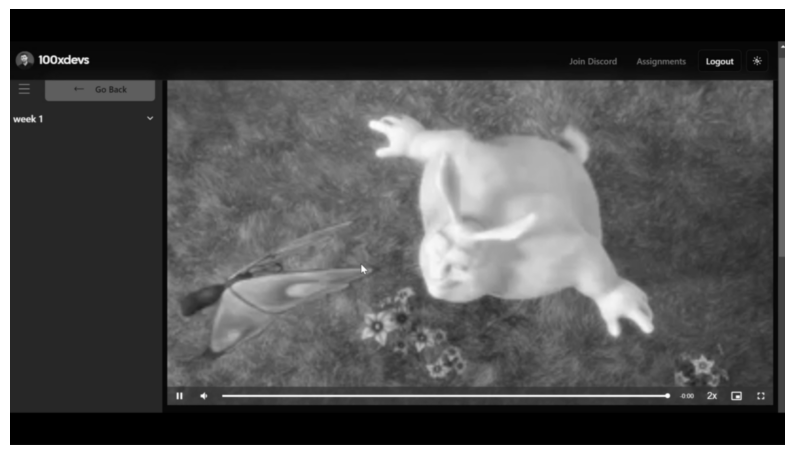

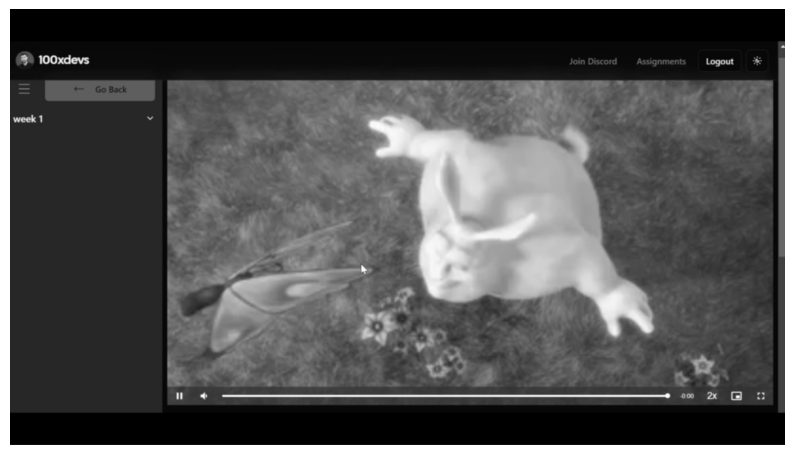

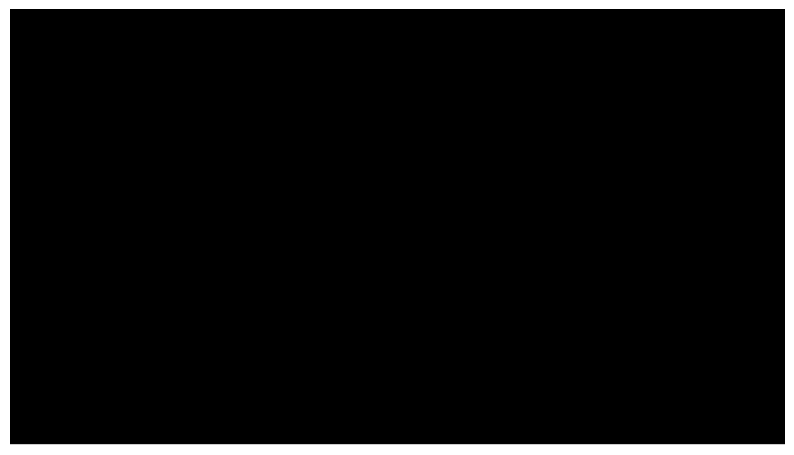

In [23]:
number=52
# highlighted_diff, isSignificant = highlight_frame_differences(cv2.cvtColor(frames1[number], cv2.COLOR_BGR2GRAY), cv2.cvtColor(frames2[number], cv2.COLOR_BGR2GRAY))
highlighted_diff, isSignificant = highlight_frame_differences(frames1[number], frames2[number])

if np.any(highlighted_diff > 0):
    print("There are values greater than 0 in the array.")
    count_greater_than_0 = np.sum(highlighted_diff > 0)
    print(f"Count of values greater than 0: {count_greater_than_0}")

# print(highlighted_diff[1079])
# display_cv2_img(cv2.cvtColor(frames1[number], cv2.COLOR_BGR2GRAY), figsize=(10, 10))
# display_cv2_img(cv2.cvtColor(frames2[number], cv2.COLOR_BGR2GRAY), figsize=(10, 10))
# display_cv2_img(highlighted_diff, figsize=(10, 10))
display_cv2_img(frames1[number], figsize=(10, 10))
display_cv2_img(frames2[number], figsize=(10, 10))
display_cv2_img(highlighted_diff, figsize=(10, 10))
print(phash1[number], phash2[number],phash1[number]-phash2[number], isSignificant)


In [24]:
# for i in range(0,len(frames1)):
i=0
while i<len(frames1):
    # number=i
    # highlighted_diff, isSignificant = highlight_frame_differences(cv2.cvtColor(frames1[i], cv2.COLOR_BGR2GRAY), cv2.cvtColor(frames2[i], cv2.COLOR_BGR2GRAY))
    highlighted_diff, isSignificant = highlight_frame_differences(frames1[i],frames2[i])
    # print(number)
    if isSignificant:
        print(i)

        upload_segment(i//300)
        # print(i)
        # display_cv2_img(highlighted_diff, figsize=(10, 10))
        i=(i+300)-(i%300)
        # print("Updated i= ",i)
    i+=1

3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant_pixels
3840 num_significant

In [25]:
# cap = cv2.VideoCapture('main_copy.mp4')
# ret, frame = cap.read()
# frame

In [26]:
# array_bytes = frame.tobytes()
# print(array_bytes)
# hash_object = hashlib.sha256(array_bytes)
# hash_digest = hash_object.hexdigest()

# print("Hash Digest:", hash_digest)
# frame.tobytes()
# stringFrame2=str(frame)
# print(stringFrame2)

In [27]:
# stringFrame1==stringFrame2

In [28]:
# hash_object = hashlib.md5(stringFrame1.encode())

# # Get the hexadecimal representation of the hash digest
# hash_digest = hash_object.hexdigest()
# print(hash_digest)
# hash_object2 = hashlib.md5(stringFrame2.encode())

# # Get the hexadecimal representation of the hash digest
# hash_digest2 = hash_object2.hexdigest()
# print(hash_digest2)

In [29]:
# cap2 = cv2.VideoCapture('main_edit.mp4')
# # Create an empty list to store hash digests
# hash_digests2 = []
# strings2=[]

# while cap2.isOpened():
#     # Read a frame
#     ret, frame = cap2.read()

#     # Check if the frame was read successfully
#     if not ret:
#         break  # Break the loop if the end of the video is reached

#     # Process the frame (you can perform any desired processing here)
#     # For example, display the frame
#     # array_bytes = frame.tobytes()
#     # hash_object = hashlib.sha256(array_bytes)
#     # hash_digest = hash_object.hexdigest()

#     my_string=str(frame)
#     strings2.append(my_string)
#     # Calculate hash using MD5 without encoding
#     hash_object = hashlib.md5(my_string.encode())

#     # Get the hexadecimal representation of the hash digest
#     hash_digest = hash_object.hexdigest()

#     hash_digests2.append(hash_digest)

#     # print("Hash Digest:", hash_digest)
#     # cv2.imshow('Video', frame)

In [30]:
strings1[1]

IndexError: list index out of range

In [ ]:
strings2[1]

'[[[ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]\n  ...\n  [ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]]\n\n [[ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]\n  ...\n  [ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]]\n\n [[ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]\n  ...\n  [ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]]\n\n ...\n\n [[ 1  1  1]\n  [ 1  1  1]\n  [ 1  1  1]\n  ...\n  [ 1  1  1]\n  [ 1  1  1]\n  [ 1  1  1]]\n\n [[ 0 11  0]\n  [ 0 11  0]\n  [ 0 11  0]\n  ...\n  [ 0 11  0]\n  [ 0 11  0]\n  [ 0 11  0]]\n\n [[14 40 18]\n  [14 40 18]\n  [14 40 18]\n  ...\n  [14 40 18]\n  [14 40 18]\n  [14 40 18]]]'

In [ ]:
len(hash_digests2)

685

In [ ]:
print(hash_digests1[0])
print(hash_digests2[0])

fcf72db83cfc9c29035fead0804f0fac
fcf72db83cfc9c29035fead0804f0fac


In [ ]:
hash_digests1

['fcf72db83cfc9c29035fead0804f0fac',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 

In [ ]:
hash_digests2

['fcf72db83cfc9c29035fead0804f0fac',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 'a19485d6edb9fb292a131fd71e28e526',
 

In [ ]:
for i in range(0, len(hash_digest)):
    if hash_digests1[i]!=hash_digests2[i]:
        print(i)

NameError: name 'hash_digest' is not defined